In [1]:
# Example1: assume data follow a normal distribution
# Cut off data points in low probability regions

import statistics

data = [23.0, 28.8, 28.9, 28.9, 28.9, 29.0, 29.1, 29.1, 29.2, 29.2, 29.3, 29.4, 29.5, 
        29.5, 29.6, 29.7, 29.7, 29.8, 29.8, 29.9, 29.9, 35.0]


def find_outliers_normal_dist(data):
    outliers = []
    # Set upper and lower limit to 3 standard deviation
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    cut_off = data_std * 3
    lower_limit  = data_mean - cut_off 
    upper_limit = data_mean + cut_off
    print(f'Lower limit: {lower_limit}')
    print(f'Upper limit: {upper_limit}')
    for d in data:
        if d > upper_limit or d < lower_limit:
            outliers.append(d)
    return outliers

outliers = find_outliers_normal_dist(data)
outliers


Lower limit: 23.665232344274628
Upper limit: 34.98931311027083


[23.0, 35.0]

<AxesSubplot:>

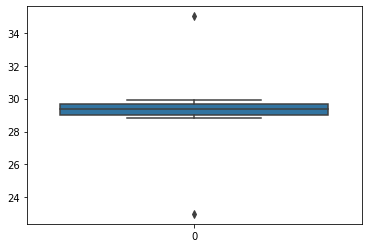

In [2]:
# Example2: Use boxplots to locate outliers in the same data
# Similar idea as with the normal distribution. 
# Boxplots calculate the IQR
# Outliers: below (Q1 − 1.5x IQR) or above (Q3 + 1.5x IQR)

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data)

In [3]:
# How box plot works:

from numpy import percentile

def find_outliers_iqr(data):
    outliers = []
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print(f'Percentiles: 25th={q25}, 75th={q75}, IQR={iqr}')
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower = q25 - cut_off
    upper = q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    return outliers

outliers = find_outliers_iqr(data)
outliers

Percentiles: 25th=29.025, 75th=29.7, IQR=0.6750000000000007


[23.0, 35.0]

In [4]:
# Example3: Use DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN

X = [
    [23.0],
    [28.8],
    [28.9],
    [28.9],
    [28.9],
    [29.0],
    [29.1],
    [29.1],
    [29.2],
    [29.2],
    [29.3],
    [29.4],
    [29.5],
    [29.5],
    [29.6],
    [29.7],
    [29.7],
    [29.8],
    [29.8],
    [29.9],
    [29.9],
    [35.0]
]

outlier_detection = DBSCAN(eps=0.2,min_samples=5,metric='euclidean')
clusters = outlier_detection.fit_predict(X)
list(clusters)


[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

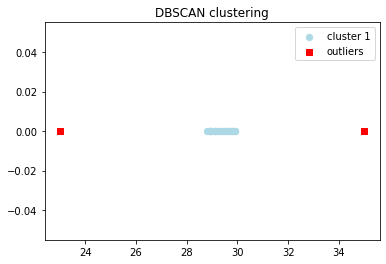

In [5]:
import matplotlib.pyplot as plt

cl1=[point[0] for i,point in enumerate(X) if clusters[i]==0]
cl2=[point[0] for i,point in enumerate(X) if clusters[i]==-1]
y1=[0 for i in cl1]
y2=[0 for i in cl2]
plt.scatter(cl1,y1,c='lightblue',marker='o',s=40,label='cluster 1')
plt.scatter(cl2,y2,c='red',marker='s',s=40,label='outliers')
plt.title('DBSCAN clustering')
plt.legend()
plt.show()

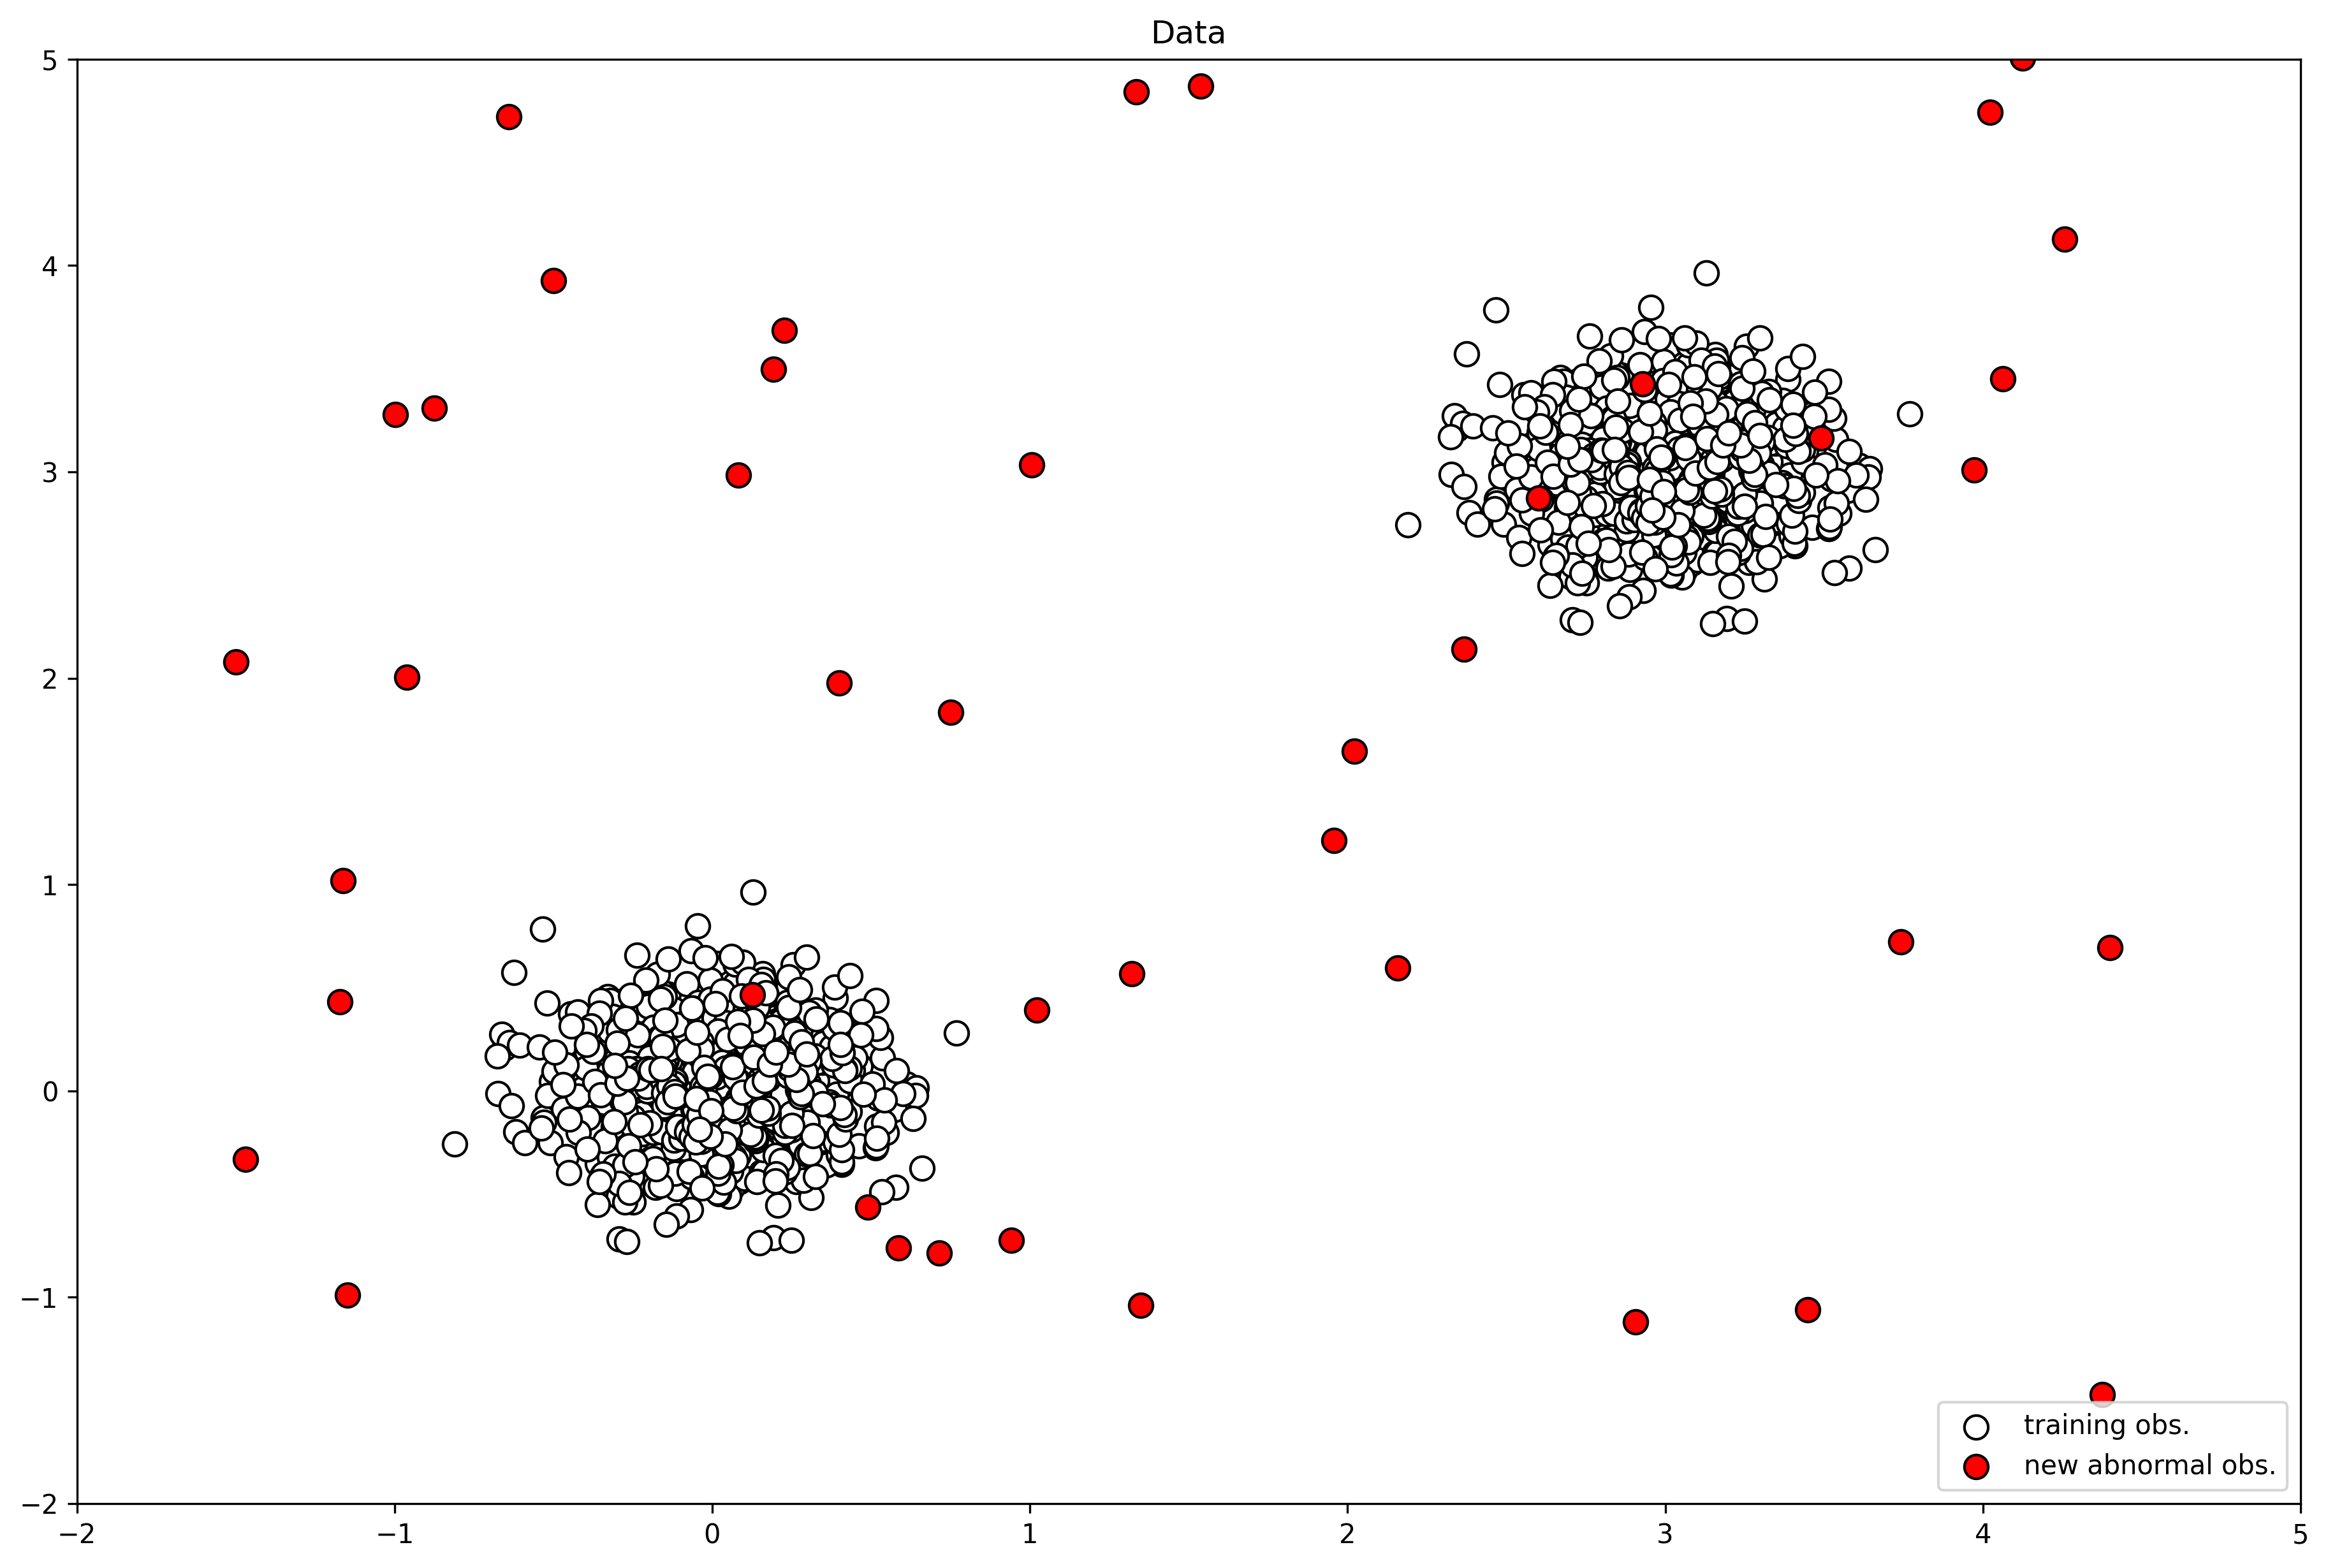

In [9]:
# Example using Isolation Forest
#
# Isolation Forest explicitly identifies anomalies instead of modeling the normal data. 
# The algorithm is built on the basis of decision trees. 
# Partitions are created by first randomly selecting a feature and then selecting a random split value 
# between the minimum and maximum value of the selected feature.

# Assumption: Outliers are less frequent than regular observations
# and are different from normal data in terms of values.

# That is why by using such random partitioning they should be identified 
# closer to the root of the tree. 
# The idea is that normal observations require more partitions to be identified than abnormal.
# The outlier score (anomaly score) is based on the path length of the observation.

# Isolation Forest has the capacity to scale up to handle extremely
# large data size and high-dimensional problems with a large number of irrelevant attributes.
# Paper: https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf


# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

# Set figures parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [15, 10]

rng = np.random.RandomState(42)

# Generate data 
X_train = 0.25 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])


# Generating outliers
X_outliers = rng.uniform(low=-1.5, high=5.5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

# Plot data
plt.title("Data")
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')
plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2],
           ["training obs.",
            "new abnormal obs."],
           loc="lower right")

plt.show()

In [10]:
# Isolation Forest

# Fit on training set
# max samples: num of samples to draw for training.
# contamination: the proportion of outliers in the data set. (use auto if not sure)
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng) 
clf.fit(X_train)

# Predict on all sets
y_pred_train = clf.predict(X_train)
y_pred_outliers = clf.predict(X_outliers)


In [12]:
# Accuracy on normal training observations
# We know that all the train observations should be normal.
# So, divide the correct predictions to the length of the train observations.
# The correct predictions are those labeled "1"
print("Accuracy:", list(y_pred_train).count(1)/y_pred_train.shape[0])

Accuracy: 0.9


In [13]:
# Accuracy on abnormal (outlier) observations
# We know that all the outlier (X_outlier) observations whould be abnormal.
# So, divide the correct predictions to the length of the outlier observations.
# The correct predictions are those labeled "-1" (outliers).
print("Accuracy:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy: 0.94


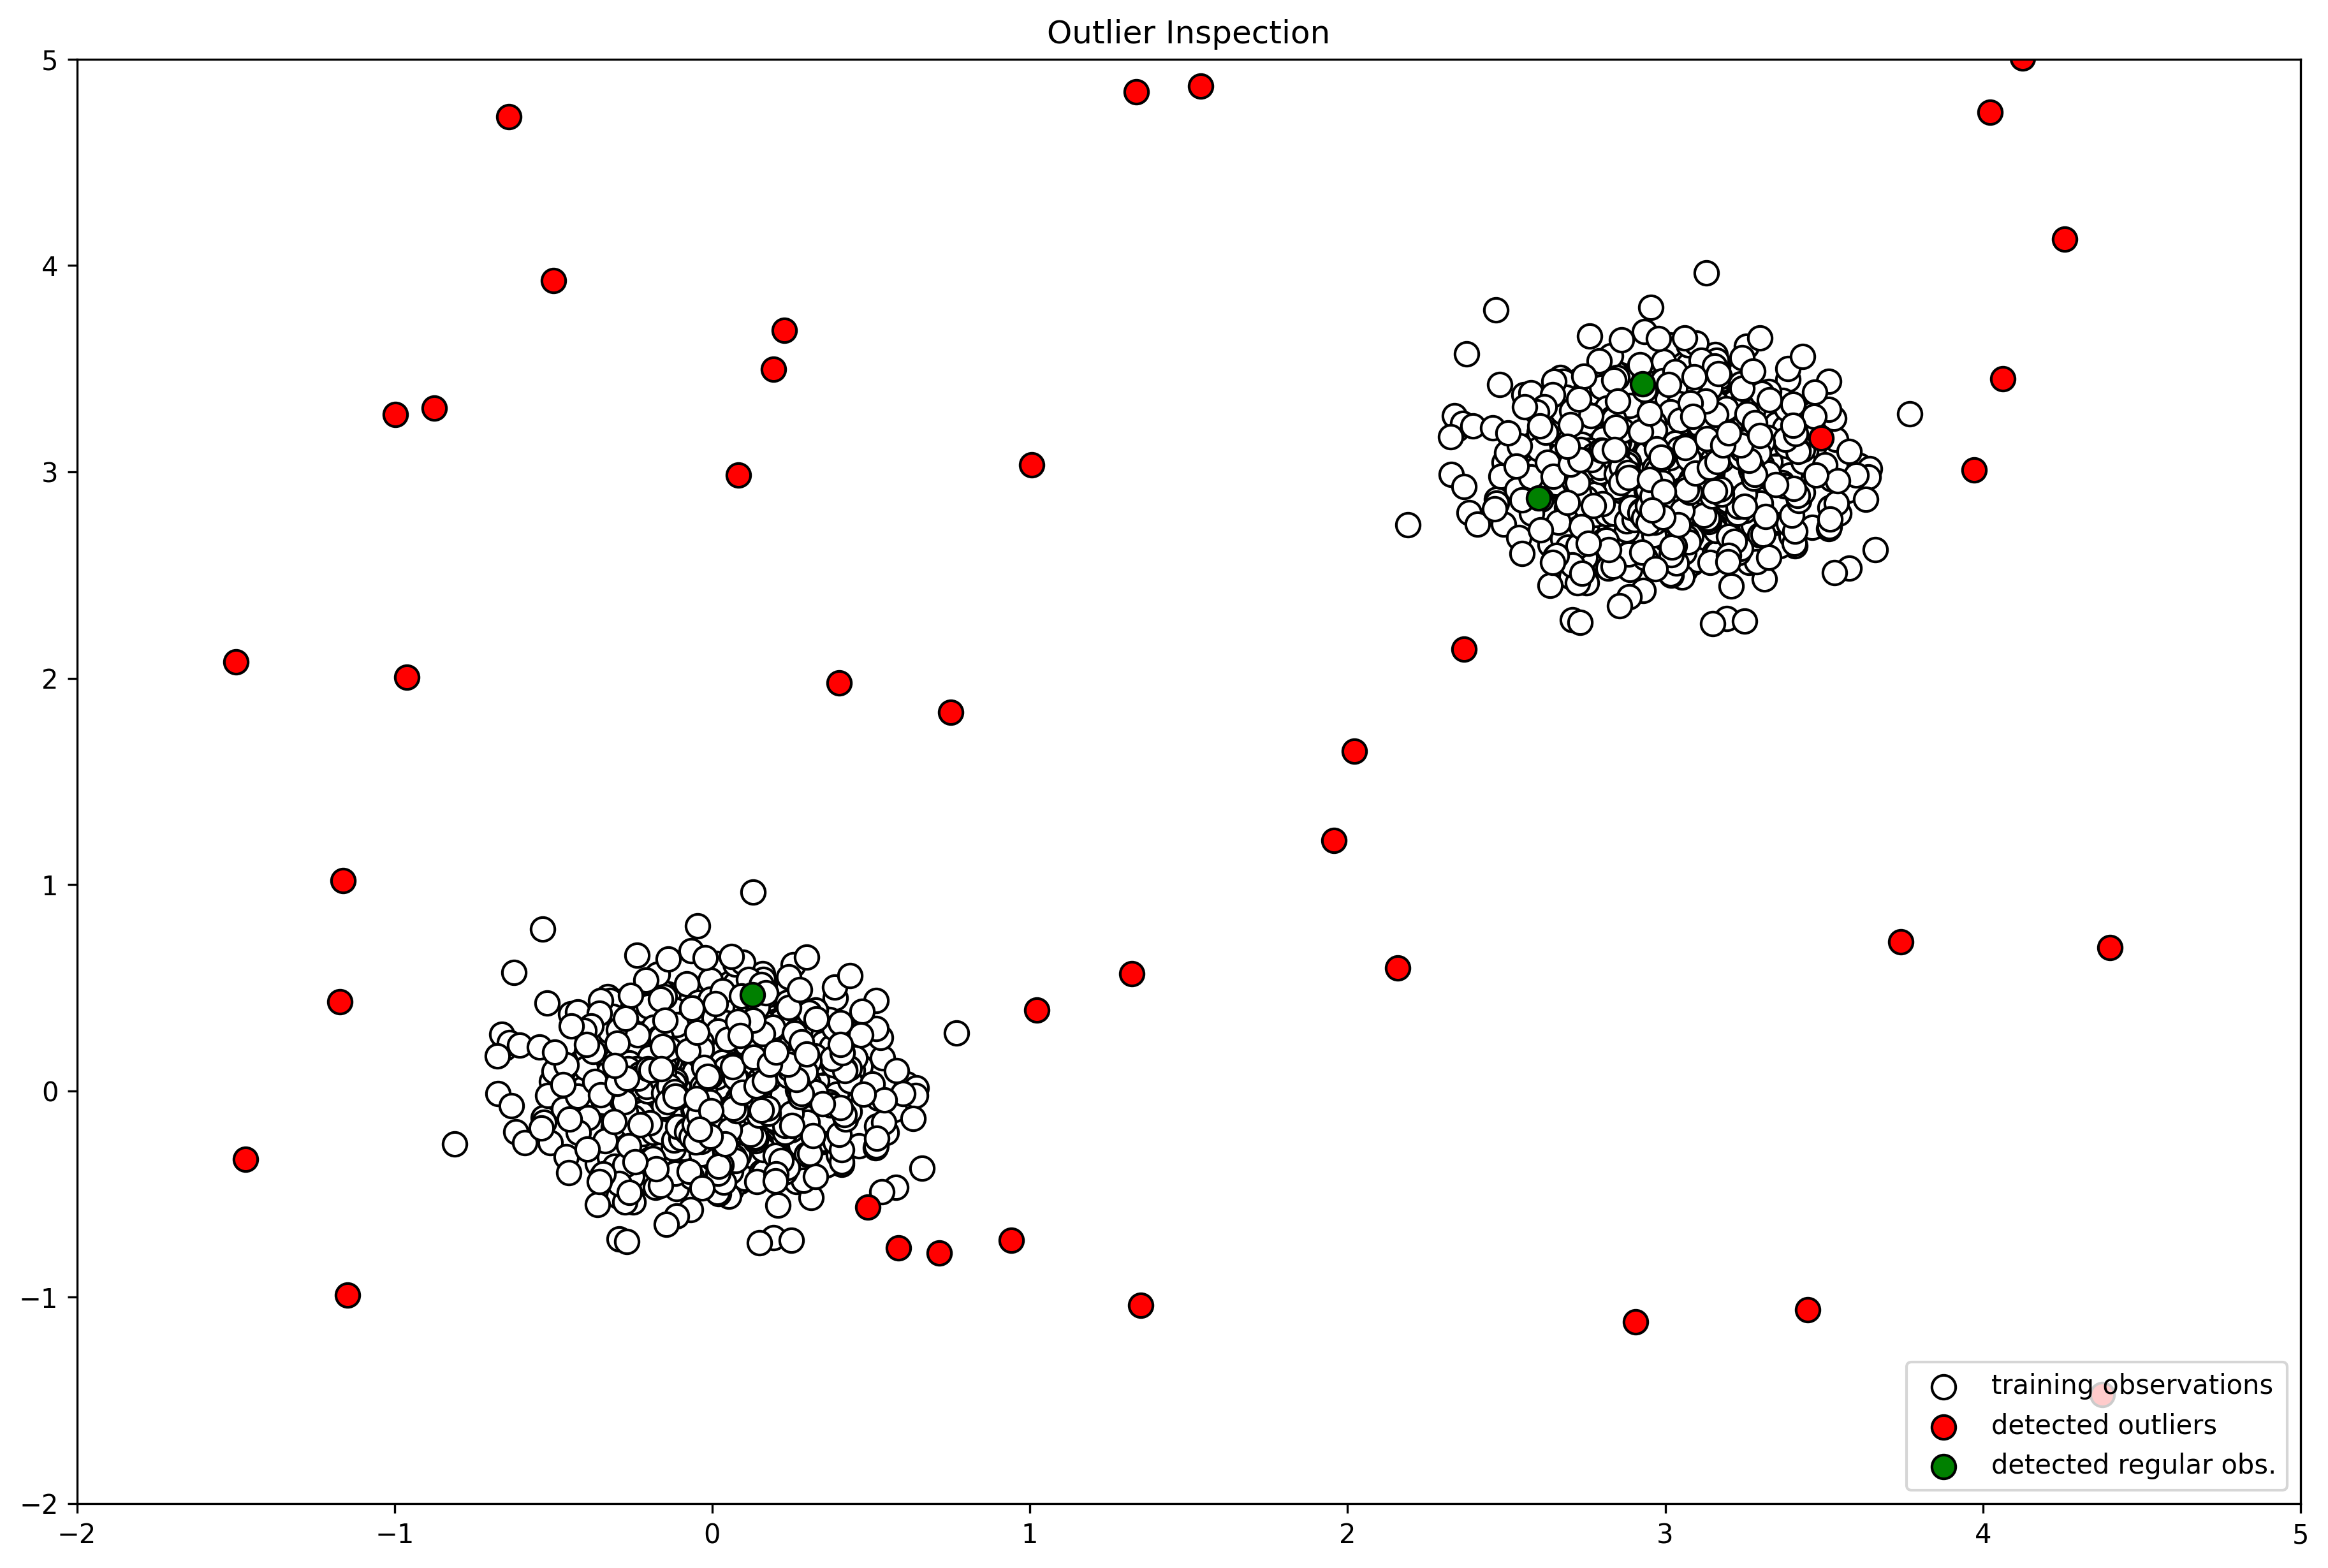

In [14]:
# Plot results
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Outlier Inspection")
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["training observations",
            "detected outliers", 
            "detected regular obs."],
           loc="lower right")
plt.show()

